<a href="https://colab.research.google.com/github/aryaagarwaal/ddls-course-2024/blob/main/MelanomaPrimary%26MetastaticWSI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Metastatic and Primary Melanoma Tumor Identification Using Whole Slide Images (WSI)
This project processes Whole Slide Images (WSI) of metastatic and primary melanoma tumor tissues to extract regions of interest (ROIs), train a Vision Transformer (ViT) model, and generate Grad-CAM visualizations to interpret model predictions.

**Table of Contents**

1. Installation
2. Dataset Structure
3. Processing WSIs
4. Extracting Regions of Interest (ROIs)
5. Loading and Splitting Data
6. Training Vision Transformer (ViT) Model
7. Model Evaluation and Visualization
8. Grad-CAM Visualization






**1. Installation**

To run this project, you'll need the following Python packages installed:

In [ ]:
!pip install openslide-python
!apt-get install openslide-tools
!pip install Pillow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 359.0/359.0 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for openslide-python: filename=openslide_python-1.3.1-cp310-cp310-linux_x86_64.whl size=33548 sha256=084310b64ba7afd2a7875b8067244486096408c5932de51f6cabf3cab5f7a84e
  Stored in directory: /root/.cache/pip/wheels/79/79/fa/29a0087493c69dff7fd0b70fab5d6771002a531010161d2d97
Successfully built openslide-python
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 49 not upgraded.
Need to get 104 kB of archives.
After this operation, 297 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libopenslide0 amd64 3.4.1+dfsg-5build1 [89.8 kB]

Mount your Google Drive whiel using Google Colab:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**2. Import Required Libraries**

Libraries for image processing, machine learning, and file management are imported.

In [ ]:
import os
import openslide
import random
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from PIL import Image
Image.MAX_IMAGE_PIXELS = None  # Disable the limit completely
import cv2
from skimage import measure
import tensorflow.keras.backend as K
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt


**3. Path Specifications**

Set paths for folders containing primary and metastatic WSI files and for saving output images and extracted ROIs.

In [ ]:
#Path specification for Primary WSI
primary_folder = '/content/drive/MyDrive/Arya_Data/Primary TCGA-SKCM'

# Output folder where downsampled .svs files or regions of interest (ROI) will be saved
output_folder = '/content/drive/My Drive/Arya_Data/output_downsampled/primary'

# Create output folder if it doesn't exist
if not os.path.exists(output_folder):
   os.makedirs(output_folder)

#Path specification for Metastatic WSI
metastatic_folder = '/content/drive/MyDrive/Arya_Data/Metastatic TCGA-SKCM'
output_folder = '/content/drive/My Drive/Arya_Data/output_downsampled/metastatic'

# Create output folder if it doesn't exist
if not os.path.exists(output_folder):
   os.makedirs(output_folder)


**4. Process and Downsample WSI Files**

The process_svs_file function processes WSI files by downsampling them to a lower resolution to reduce memory usage. The processed images are saved in the specified folder.



In [ ]:
def process_svs_file(svs_folder, output_folder, level=1):
    # Loop through all .svs files in the folder
    for file_name in os.listdir(svs_folder):
        if file_name.endswith('.svs'):
            svs_path = os.path.join(svs_folder, file_name)

            # Open the .svs file
            slide = openslide.OpenSlide(svs_path)

            # Choose a lower resolution level (e.g., level 1 or 2) to reduce memory usage
            level_dimensions = slide.level_dimensions[level]
            print(f"Processing {file_name} at level {level} with dimensions {level_dimensions}")

            # Read a lower resolution of the entire slide
            img = slide.read_region((0, 0), level, level_dimensions)

            # Save the downsampled image (optional - only save as .svs or PIL Image)
            output_path = os.path.join(output_folder, file_name.replace('.svs', '.png'))
            img.save(output_path)
            print(f"Processed {file_name} and saved downsampled version to {output_path}")

# Process .svs files from both folders at a lower resolution (level 1)
process_svs_file(primary_folder, output_folder, level=1)
process_svs_file(metastatic_folder, output_folder, level=1)


**5. ROI Extraction and Color Segmentation**

The extract_and_save_rois function extracts regions of interest (ROIs) based on color segmentation (purple/red regions) using OpenCV and Scikit-Image. The extracted ROIs are resized to 224x224 pixels and saved as .png files.

In [ ]:
# Paths to folders
primary_folder = '/content/drive/MyDrive/Arya_Data/output_downsampled/primary'
metastatic_folder = '/content/drive/MyDrive/Arya_Data/output_downsampled/metastatic'

# Create output directories for saving ROIs
primary_save_folder = '/content/drive/MyDrive/Arya_Data/output_downsampled/primary_rois'
metastatic_save_folder = '/content/drive/MyDrive/Arya_Data/output_downsampled/metastatic_rois'
os.makedirs(primary_save_folder, exist_ok=True)
os.makedirs(metastatic_save_folder, exist_ok=True)

# Function to extract ROIs and save them
def extract_and_save_rois(image, save_folder, base_filename):
    # Convert image to HSV color space for better color segmentation
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Define the HSV color bounds for purple and red tissue regions
    lower_bound = np.array([110, 50, 50])  # Lower bound for purple/red
    upper_bound = np.array([180, 255, 255])  # Upper bound

    # Create a mask to isolate the tissue
    mask = cv2.inRange(hsv, lower_bound, upper_bound)

    # Remove small noise with morphological operations
    kernel = np.ones((5, 5), np.uint8)
    mask_cleaned = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    # Label connected components
    labels = label(mask_cleaned)
    regions = regionprops(labels)

    # Loop over each connected component and save the ROI
    roi_count = 0
    for region in measure.regionprops(labels):
        if region.area >= 500:  # Filter out small regions that may be noise
            min_row, min_col, max_row, max_col = region.bbox
            roi = image[min_row:max_row, min_col:max_col]

            # Resize the ROI to 224x224 for model input
            resized_roi = cv2.resize(roi, (224, 224))

            # Construct the save path for the ROI
            roi_filename = f"{base_filename}_roi_{roi_count}.png"
            save_path = os.path.join(save_folder, roi_filename)

            # Save the extracted ROI as a .png file
            cv2.imwrite(save_path, resized_roi)

            roi_count += 1

    print(f"Extracted {roi_count} ROIs from {base_filename}.")

# Function to load images from a folder, extract and save ROIs
def process_folder(folder, save_folder, label):
    for file_name in os.listdir(folder):
        file_path = os.path.join(folder, file_name)
        if file_name.endswith('.png'):
            img = cv2.imread(file_path)
            base_filename = os.path.splitext(file_name)[0]  # Remove file extension for naming
            extract_and_save_rois(img, save_folder, base_filename)

# Process and save ROIs for both primary and metastatic tumor images
process_folder(primary_folder, primary_save_folder, 0)
print("Primary ROIs saved.")
process_folder(metastatic_folder, metastatic_save_folder, 1)
print("Metastatic ROIs saved.")



**6. Load and Split Data**

After extracting ROIs, the data is loaded, shuffled, and split into an 80-20 train-test split.



In [ ]:
def load_data_from_folder(folder, label):
    data = []
    for file_name in os.listdir(folder):
        file_path = os.path.join(folder, file_name)
        if file_name.endswith('.png'):
            img = cv2.imread(file_path)
            img_array = cv2.resize(img, (224, 224))  # Ensure size is correct
            data.append((img_array, label))
    return data

# Load data for both primary and metastatic
primary_data = load_data_from_folder(primary_save_folder, 0)
metastatic_data = load_data_from_folder(metastatic_save_folder, 1)

# Combine and shuffle the data
all_data = primary_data + metastatic_data
random.shuffle(all_data)

# Split data into images and labels
images, labels = zip(*all_data)
# Split into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

**7. Save Data**

The training and testing datasets are saved as .npy and .npz files for later use.

In [ ]:
# Convert the images and labels to NumPy arrays
X_train_np = np.array(X_train)
y_train_np = np.array(y_train)
X_test_np = np.array(X_test)
y_test_np = np.array(y_test)

# Save the data using NumPy as individual files
np.save('X_train.npy', X_train_np)
np.save('y_train.npy', y_train_np)
np.save('X_test.npy', X_test_np)
np.save('y_test.npy', y_test_np)

# Optionally, save everything in a compressed .npz file
np.savez_compressed('tumor_data.npz', X_train=X_train_np, y_train=y_train_np, X_test=X_test_np, y_test=y_test_np)

print("Data has been saved successfully!")

Data has been saved successfully!


**8. Vision Transformer (ViT) Model Creation**

The Vision Transformer model is built using TensorFlow and Keras. It processes the 224x224 images and performs classification into primary or metastatic tumor classes.

The model is compiled and trained on the dataset using 25 epochs.

In [ ]:
# Load the saved .npy files
X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')
X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')

# Create TensorFlow datasets from NumPy arrays
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1024).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

# Vision Transformer (ViT) model
def create_vit_model(input_shape=(224, 224, 3), num_classes=2):
    inputs = layers.Input(shape=input_shape)

    # Patch extraction
    patches = layers.Conv2D(768, kernel_size=(16, 16), strides=(16, 16))(inputs)

    # Flatten patches
    flat_patches = layers.Reshape((-1, 768))(patches)

    # Add spatial attention (optional)
    attention = layers.MultiHeadAttention(num_heads=8, key_dim=768)(flat_patches, flat_patches)

    # Transformer encoder layers
    x = layers.LayerNormalization()(attention)
    x = layers.Dense(2048, activation='relu')(x)
    x = layers.Dense(768)(x)

    # Final classification
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(512, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Create TensorFlow datasets from NumPy arrays
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1024).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

# Compile and train the model
vit_model = create_vit_model()
vit_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model using TensorFlow datasets
history = vit_model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=25
)


Epoch 1/25
718/718 ━━━━━━━━━━━━━━━━━━━━ 209s 268ms/step - accuracy: 0.5294 - loss: 0.8857 - val_accuracy: 0.5349 - val_loss: 0.6907
Epoch 2/25
718/718 ━━━━━━━━━━━━━━━━━━━━ 185s 258ms/step - accuracy: 0.5358 - loss: 0.6912 - val_accuracy: 0.5349 - val_loss: 0.6907
Epoch 3/25
718/718 ━━━━━━━━━━━━━━━━━━━━ 185s 258ms/step - accuracy: 0.5407 - loss: 0.6903 - val_accuracy: 0.5349 - val_loss: 0.6909
Epoch 4/25
718/718 ━━━━━━━━━━━━━━━━━━━━ 185s 258ms/step - accuracy: 0.5359 - loss: 0.6907 - val_accuracy: 0.5349 - val_loss: 0.6908
Epoch 5/25
718/718 ━━━━━━━━━━━━━━━━━━━━ 185s 258ms/step - accuracy: 0.5381 - loss: 0.6906 - val_accuracy: 0.5349 - val_loss: 0.6907
Epoch 6/25
718/718 ━━━━━━━━━━━━━━━━━━━━ 185s 258ms/step - accuracy: 0.5393 - loss: 0.6904 - val_accuracy: 0.5349 - val_loss: 0.6908
Epoch 7/25
718/718 ━━━━━━━━━━━━━━━━━━━━ 185s 258ms/step - accuracy: 0.5371 - loss: 0.6905 - val_accuracy: 0.5349 - val_loss: 0.6907
Epoch 8/25
718/718 ━━━━━━━━━━━━━━━━━━━━ 185s 258ms/step - accuracy: 0.5384 -

**9. Evaluation and Metrics**

The model's predictions are evaluated using accuracy, precision, recall, and confusion matrix.

180/180 ━━━━━━━━━━━━━━━━━━━━ 16s 88ms/step


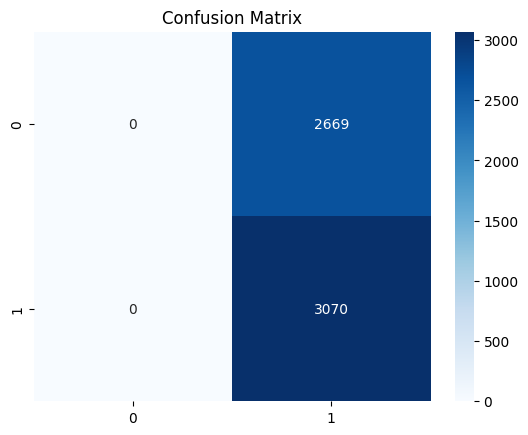

Accuracy: 0.53, Precision: 0.53, Recall: 1.00


In [ ]:
# Predictions on the test set
y_pred = vit_model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Calculate accuracy, precision, recall
accuracy = accuracy_score(y_test, y_pred_labels)
precision = precision_score(y_test, y_pred_labels)
recall = recall_score(y_test, y_pred_labels)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_labels)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

print(f"Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}")


**10. Grad-CAM Visualization**

The Grad-CAM technique is used to visualize the regions of the image that the ViT model focuses on for classification.



Heatmap values: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


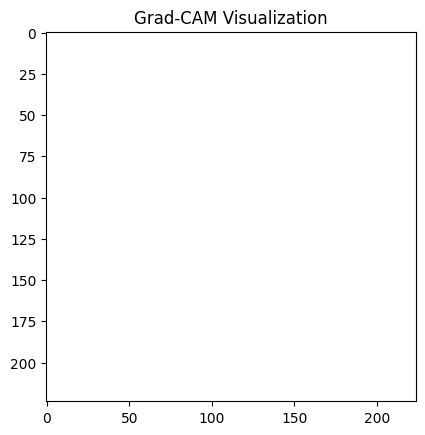

In [ ]:
# Grad-CAM function with dynamic handling of dimensions and shape logging
def grad_cam_debug(model, img, layer_name):
    grad_model = models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.array([img]))
        loss = predictions[:, 1]  # Class of interest (e.g., metastatic)

    # Get gradients of the loss with respect to the output feature map
    grads = tape.gradient(loss, conv_outputs)[0]
    conv_output_dims = len(conv_outputs.shape)

    # Handle different output dimensions
    if conv_output_dims == 4:
        pooled_grads = K.mean(grads, axis=(0, 1, 2))
        conv_outputs = conv_outputs[0]
        for i in range(conv_outputs.shape[-1]):
            conv_outputs[:, :, i] *= pooled_grads[i]
    elif conv_output_dims == 3:
        pooled_grads = K.mean(grads, axis=(0, 1))
        conv_outputs = conv_outputs[0]
        conv_outputs *= pooled_grads
    elif conv_output_dims == 2:
        pooled_grads = K.mean(grads, axis=0)
        conv_outputs = conv_outputs[0]
        conv_outputs *= pooled_grads

    # Compute heatmap and ensure it's normalized properly
    if conv_output_dims == 4 or conv_output_dims == 3:
        heatmap = np.mean(conv_outputs, axis=-1)
    else:
        heatmap = conv_outputs

    # Print heatmap for debugging
    print(f"Heatmap values: {heatmap}")

    heatmap = np.maximum(heatmap, 0)  # ReLU to retain only positive gradients
    heatmap = np.nan_to_num(heatmap)  # Avoid NaN values
    if np.max(heatmap) > 0:
        heatmap /= np.max(heatmap)  # Normalize heatmap

    return heatmap

# Generate the heatmap for a test image
layer_name = 'multi_head_attention_1'
heatmap = grad_cam_debug(vit_model, X_test[0], layer_name)

# Superimpose heatmap on original image
img = X_test[0]
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = heatmap * 0.4 + img
plt.imshow(superimposed_img)
plt.title('Grad-CAM Visualization')
plt.show()